This is the notebook to show the implementation of score-based generative model with SDE (2nd part of the tutorial). In this case, we will sample the training data from the swiss roll distribution like the previous part.
From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)

In [1]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

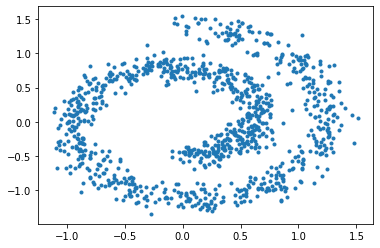

In [2]:
# show the samples
import matplotlib.pyplot as plt
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

Now let's define the neural network that will learn the score function.
This is just a simple multi-layer perceptron with LogSigmoid activation function.
I used logsigmoid because of personal preference, you can also use ReLU.

In [3]:
# score_network takes input of 2 + 1 (time) and returns the output of the same size (2)
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

Now let's implement the denoising score matching function below,
$$\begin{equation}
\mathcal{L}(\theta) = \int_0^1\lambda (t) \mathbb{E}_{\mathbf{x}(0)}\mathbb{E}_{\mathbf{x}(t)|\mathbf{x}(0)}\left[\left\lVert\mathbf{s}(\mathbf{x}(t), t; \theta) - \nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0))\right\rVert^2\right]\ dt
\end{equation}$$
where $\lambda(t) = 1 - \mathrm{exp}\left[-\int_0^t \beta(s) ds\right]$ and $\nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0))$ can be calculated analytically,
$$\begin{align}
\nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0)) &= -\frac{\mathbf{x}(t) - \boldsymbol{\mu}(t)}{\sigma^2(t)} \\
\boldsymbol{\mu}(t) &= \mathbf{x}(0)\mathrm{exp}\left[-\frac{1}{2}\int_0^t \beta(s) ds\right] \\
\sigma^2(t) &= 1 - \mathrm{exp}\left[-\int_0^t \beta(s) ds\right]
\end{align}$$
with $\beta(t) = 0.1 + (20 - 0.1) t$.

In [4]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    
    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, 2)
    
    # calculate the score function
    xt = torch.cat((x_t, t), dim=-1)  # (batch_size, 3)
    score = score_network(xt)  # score: (batch_size, 2)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)


Everything is ready, now we can start the training.

In [5]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
for i_epoch in range(150000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 10000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")


0 (0.042441368103027344s): 1.0375168743133545
10000 (92.2302143573761s): 0.20365591967105864
20000 (185.08470916748047s): 0.22875319838523864
30000 (281.3716654777527s): 0.21506413650512696
40000 (381.3604953289032s): 0.18730134618282318
50000 (480.49600076675415s): 0.20452004408836363
60000 (577.897787809372s): 0.21503965973854064
70000 (676.1737062931061s): 0.1996930924654007
80000 (776.0507819652557s): 0.21714348602294922
90000 (876.1378817558289s): 0.20224706172943116
100000 (974.7899713516235s): 0.18862251448631287
110000 (1073.5986211299896s): 0.1907759370803833
120000 (1172.9861385822296s): 0.1956720690727234
130000 (1271.3041791915894s): 0.19564533567428588
140000 (1370.8661642074585s): 0.2035321000814438


Once the neural network is trained, we can generate the samples using reverse SDE

$$\begin{equation}
\mathrm{d}\mathbf{x} = \left[\mathbf{f}(\mathbf{x}, t) - g(t)^2\mathbf{s}(\mathbf{x}, t; \theta)\right]\ \mathrm{d}t + g(t)\ \mathrm{d}\mathbf{w},
\end{equation}$$

where $\mathbf{f}(\mathbf{x}, t) = -\frac{1}{2}\beta(t)\mathbf{x}$, $g(t) = \sqrt{\beta(t)}$, and the integration time goes from 1 to 0.
To solve the SDE, we can use the Euler-Maruyama method.

In [6]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(torch.cat((x_t, t.expand(x_t.shape[0], 1)), dim=-1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

In [7]:
samples = generate_samples(score_network, 1000).detach()

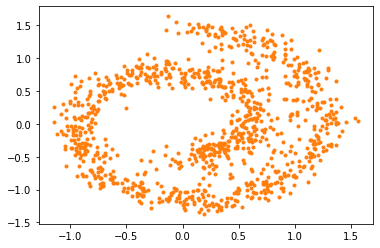

In [8]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')